# Monet Painting Generation 

**Project Goal:** Generate Monet Style paintings using Generative Adversarial Networks. 

**Dataset:** I'm Something of a Painter Myself

The project comes with four folders monet_jpg,monet_tfrec, photo_jpc, photo_tfrec. 

**Citation:** Amy Jang, Ana Sofia Uzsoy, and Phil Culliton. I’m Something of a Painter Myself. https://kaggle.com/competitions/gan-getting-started, 2020. Kaggle.

**The Challenge:** The task is to build 7000-10000 images of Monet-style. The submitted images are ecaluated using MiFID which is Memorization-informed Frechet Inception Distance. The lower the number the better the images are. 

[Kaggle Challenge](https://www.kaggle.com/competitions/gan-getting-started/overview)

Github: 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

        

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import matplotlib.pyplot as plt
from PIL import Image
import random
import shutil
import tensorflow as tf
from tensorflow.keras import layers, models
import os
import time
import random


2025-04-23 15:08:04.456736: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745420884.654913      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745420884.710029      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


This data set contains 300 images. The folder contains 4 folders and for this project I only used the monet_jpg folder. 

In [3]:
img_folder = "/kaggle/input/gan-getting-started/monet_jpg"
img_files = os.listdir(img_folder)
print(f"Total images found: {len(img_files)}")

Total images found: 300


# Exploratory Data Analysis

Take a look at a random sample of images from this dataset. 

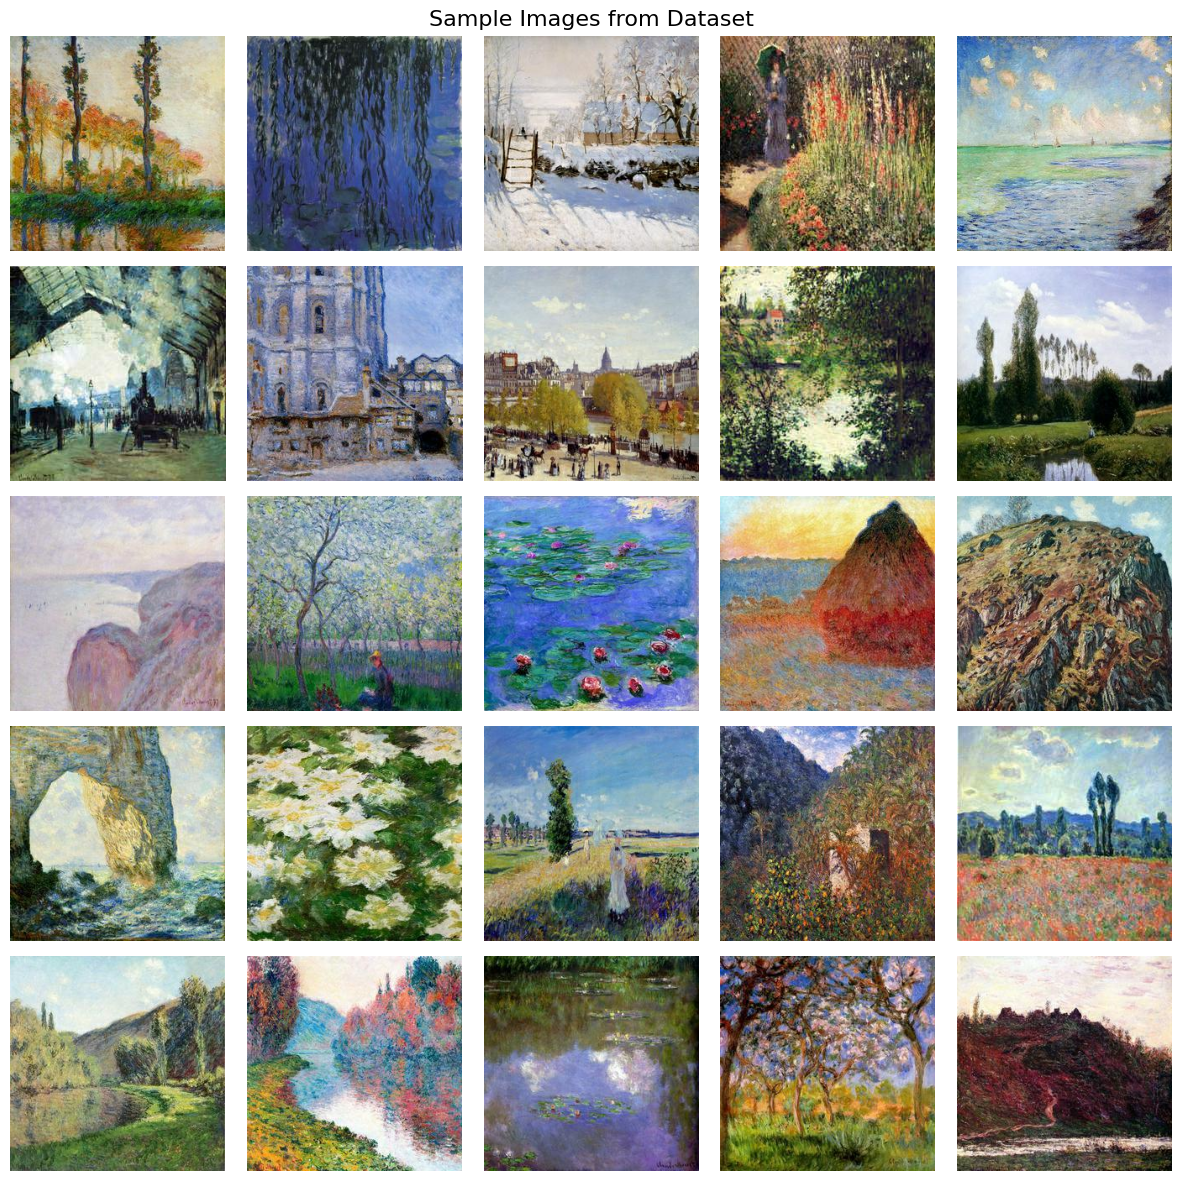

In [4]:
def show_sample_images(images, n=5):
    plt.figure(figsize=(12, 12))
    for i in range(n * n):
        img_path = os.path.join(img_folder, random.choice(images))
        img = Image.open(img_path)
        plt.subplot(n, n, i + 1)
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle("Sample Images from Dataset", fontsize=16)
    plt.tight_layout()
    plt.show()

show_sample_images(img_files)

There is unique style that is common throughout all these images. The colors and the brush strokes are unique to this style so the purpose of the model is to generate images that have that same style. 

In [5]:
sample_img = Image.open(os.path.join(img_folder, img_files[0]))
print(f"Image format: {sample_img.format}")
print(f"Image size: {sample_img.size}")
print(f"Color mode: {sample_img.mode}")

Image format: JPEG
Image size: (256, 256)
Color mode: RGB


Pixel range: min=0, max=255


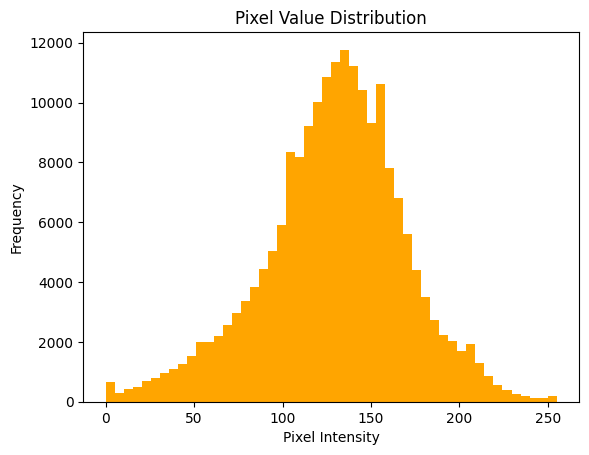

In [6]:
img_array = np.array(sample_img)
print(f"Pixel range: min={img_array.min()}, max={img_array.max()}")


plt.hist(img_array.ravel(), bins=50, color='orange')
plt.title("Pixel Value Distribution")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.show()

# Data Preprocessing

In [7]:
data_path = "/kaggle/input/gan-getting-started/monet_jpg"
IMG_SIZE = 256
BATCH_SIZE = 32
noise_dim = 100
EPOCHS = 50
AUTOTUNE = tf.data.AUTOTUNE
seed = tf.random.normal([16, noise_dim]) 

I0000 00:00:1745420900.092918      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [8]:
def preprocess_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = (img / 127.5) - 1
    return img

img_paths = [os.path.join(data_path, fname) for fname in os.listdir(data_path)]
dataset = tf.data.Dataset.from_tensor_slices(img_paths)
dataset = dataset.map(preprocess_image, num_parallel_calls=AUTOTUNE)
dataset = dataset.shuffle(1024).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Model Building

For this model I am building a Deep Convolution GAN or DCGAN. This utilizes convolutional networks in both the generator and discriminator. 

**The Generator**

The generator takes in a random noise vector and transforms it in a 256x256 RGB image throguh a seires of upsampling operations. This model uses four Conv2DTranspose layers that doubles the image size. The final layer outputs an image using tanh activation. By progressively upsampling the low dimensional noise vector gradually becomes a more high resolution 256x256 image. After each transposed convolution there is a Batch Normalization and LeakyReLU layer to stabilize training. 

In [9]:
def generator(noise_dim=100):
    model = models.Sequential()
    model.add(layers.Dense(16 * 16 * 512, input_shape=(noise_dim,))
    model.add(layers.Reshape((16, 16, 512)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2DTranspose(256, kernel_size=3, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2DTranspose(3, kernel_size=3, strides=2, padding='same', activation='tanh'))

    return model
    

**Discriminator**

The discriminator is a classifier that distinguishes real and fake images. This model takes in  a 256x256 image as input and has four convolutional layers. After each convolutional layer the model applies LeakyReLU and has dropout layers to prevent overfitting. It is continously downsampled then flattened and passed through a final dense layer using sigmoid activation to output whether it is fake or not. By preventing overfitting we make sure the generator can learn since the discriminator is not too dominant. 

In [10]:
def discriminator():
    model = models.Sequential()

    model.add(layers.Conv2D(64, kernel_size=4, strides=2, padding='same', input_shape=(256, 256, 3)))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, kernel_size=4, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, kernel_size=4, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(512, kernel_size=4, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [11]:

gen = generator()
gen.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Dense_Project (Dense)                │ (None, 131072)              │      13,238,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Reshape_To_16x16x512 (Reshape)       │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 16, 16, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 32, 32, 256)         │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 64, 64, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 128, 128, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 256, 256, 3)         │           1,731 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,792,579 (56.43 MB)

 Trainable params: 14,790,659 (56.42 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [12]:

disc= discriminator()
disc.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 64)        │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 256)         │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 512)         │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │         131,073 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,887,617 (11.02 MB)

 Trainable params: 2,887,617 (11.02 MB)

 Non-trainable params: 0 (0.00 B)

Next we define our loss functions which will be used in the training loop. The generator loss is defined using cross entrpy which measure how far the predicted probabilites are from the true. The generator loss function punishes the generator when the discriminator can see its fake and the discriminator loss function punishes the generator when the generator fools the discriminator.

In [13]:

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [14]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

In [15]:
BATCH_SIZE = 32
EPOCHS = 100
NOISE_DIM = 100

In [16]:
def generate_and_save_images(model, epoch, noise_dim=100, n=4):
    noise = tf.random.normal([n * n, noise_dim])
    predictions = model(noise, training=False)
    predictions = (predictions + 1) / 2.0 

    fig = plt.figure(figsize=(n, n))
    for i in range(predictions.shape[0]):
        plt.subplot(n, n, i + 1)
        plt.imshow(predictions[i])
        plt.axis('off')

    plt.suptitle(f"Epoch {epoch}", fontsize=16)
    plt.show()

**Training Loop**

Over each epoch we continuosly generate images to fool the discriminator and over an *n* amount of epochs the generator will get better at fooling the discriminator. This train step is called over each epoch and it generates fake images from the noise and then calculate discriminator loss. Then compute the gradients of the discrimator with respect to its own weights and update the discriminator using the discriminator optimizer. Then using new noise the generator again creates more images and then calculate generator loss against the discriminator and then calculates the gradients of the generators loss to update the generator with its optimizer.

In [17]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as disc_tape:
        generated_images = gen(noise, training=True)
        real_output = disc(images, training=True)
        fake_output = disc(generated_images, training=True)

        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_discriminator = disc_tape.gradient(disc_loss, disc.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, disc.trainable_variables))

    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])
    with tf.GradientTape() as gen_tape:
        generated_images = gen(noise, training=True)
        fake_output = disc(generated_images, training=True)

        gen_loss = generator_loss(fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, gen.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, gen.trainable_variables))

    return gen_loss, disc_loss


Above is the training step and below is the loop. For this notebook I had 100 epochs. 

In [18]:
def train(dataset, epochs):
    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        for batch in dataset:
            gen_loss, disc_loss = train_step(batch)

        print(f"Generator Loss: {gen_loss:.4f}, Discriminator Loss: {disc_loss:.4f}")

        if (epoch + 1) % 5 == 0:
            generate_and_save_images(gen, epoch + 1)


Epoch 1/100


E0000 00:00:1745420909.893245      31 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1_2/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1745420910.377273      95 cuda_dnn.cc:529] Loaded cuDNN version 90300


Generator Loss: 15.0642, Discriminator Loss: 0.1136

Epoch 2/100
Generator Loss: 4.8482, Discriminator Loss: 0.0670

Epoch 3/100
Generator Loss: 5.7926, Discriminator Loss: 0.0154

Epoch 4/100
Generator Loss: 11.2970, Discriminator Loss: 5.8090

Epoch 5/100
Generator Loss: 5.6830, Discriminator Loss: 0.0038


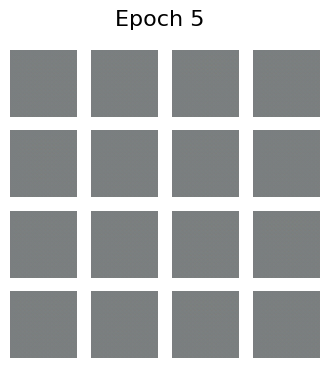


Epoch 6/100
Generator Loss: 2.9835, Discriminator Loss: 0.2716

Epoch 7/100
Generator Loss: 0.6954, Discriminator Loss: 0.1823

Epoch 8/100
Generator Loss: 2.3477, Discriminator Loss: 0.2561

Epoch 9/100
Generator Loss: 4.2497, Discriminator Loss: 0.3167

Epoch 10/100
Generator Loss: 3.9073, Discriminator Loss: 0.2929


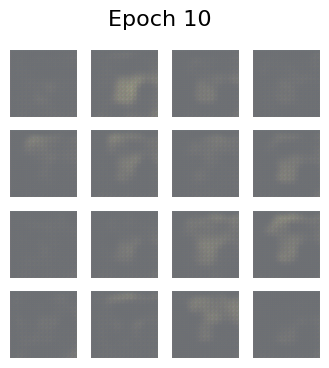


Epoch 11/100
Generator Loss: 2.4611, Discriminator Loss: 0.4335

Epoch 12/100
Generator Loss: 1.7081, Discriminator Loss: 0.7204

Epoch 13/100
Generator Loss: 1.6079, Discriminator Loss: 0.4413

Epoch 14/100
Generator Loss: 2.6088, Discriminator Loss: 0.4973

Epoch 15/100
Generator Loss: 1.3929, Discriminator Loss: 0.9170


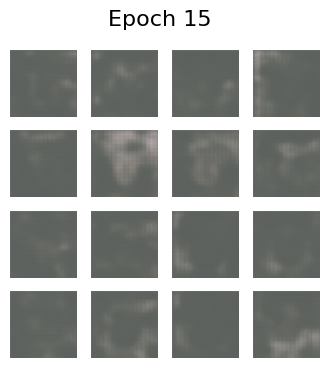


Epoch 16/100
Generator Loss: 4.1939, Discriminator Loss: 0.6537

Epoch 17/100
Generator Loss: 0.8093, Discriminator Loss: 0.7457

Epoch 18/100
Generator Loss: 1.7997, Discriminator Loss: 0.4583

Epoch 19/100
Generator Loss: 1.9014, Discriminator Loss: 0.9457

Epoch 20/100
Generator Loss: 1.3606, Discriminator Loss: 1.0996


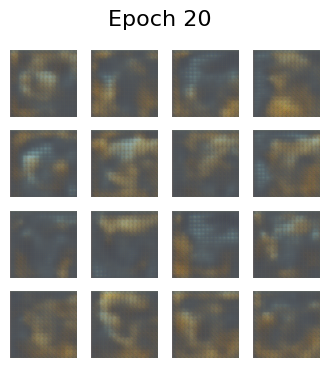


Epoch 21/100
Generator Loss: 1.6967, Discriminator Loss: 1.3488

Epoch 22/100
Generator Loss: 1.5855, Discriminator Loss: 0.7582

Epoch 23/100
Generator Loss: 1.4787, Discriminator Loss: 1.1572

Epoch 24/100
Generator Loss: 1.5927, Discriminator Loss: 0.9777

Epoch 25/100
Generator Loss: 1.5173, Discriminator Loss: 1.2841


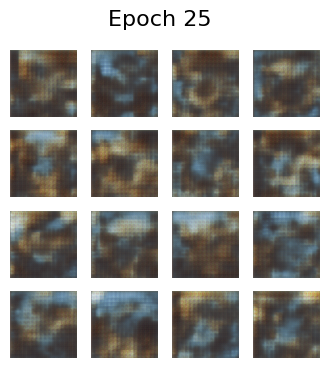


Epoch 26/100
Generator Loss: 0.7486, Discriminator Loss: 1.2583

Epoch 27/100
Generator Loss: 1.1917, Discriminator Loss: 0.9073

Epoch 28/100
Generator Loss: 2.1578, Discriminator Loss: 0.7894

Epoch 29/100
Generator Loss: 0.8763, Discriminator Loss: 1.9582

Epoch 30/100
Generator Loss: 3.1778, Discriminator Loss: 1.5133


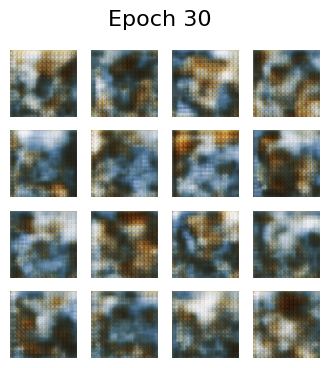


Epoch 31/100
Generator Loss: 1.3797, Discriminator Loss: 1.1514

Epoch 32/100
Generator Loss: 1.3234, Discriminator Loss: 1.0093

Epoch 33/100
Generator Loss: 2.3716, Discriminator Loss: 0.8796

Epoch 34/100
Generator Loss: 1.3203, Discriminator Loss: 1.3009

Epoch 35/100
Generator Loss: 1.4149, Discriminator Loss: 1.0172


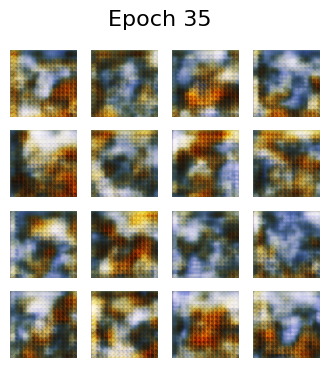


Epoch 36/100
Generator Loss: 1.8156, Discriminator Loss: 0.7636

Epoch 37/100
Generator Loss: 1.4621, Discriminator Loss: 0.8707

Epoch 38/100
Generator Loss: 1.1890, Discriminator Loss: 1.0573

Epoch 39/100
Generator Loss: 2.1971, Discriminator Loss: 1.1420

Epoch 40/100
Generator Loss: 0.5308, Discriminator Loss: 1.0728


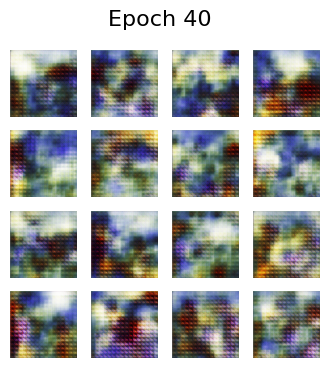


Epoch 41/100
Generator Loss: 1.5057, Discriminator Loss: 1.0587

Epoch 42/100
Generator Loss: 1.8085, Discriminator Loss: 0.7461

Epoch 43/100
Generator Loss: 1.2877, Discriminator Loss: 1.5519

Epoch 44/100
Generator Loss: 1.1968, Discriminator Loss: 1.0163

Epoch 45/100
Generator Loss: 1.2685, Discriminator Loss: 1.0986


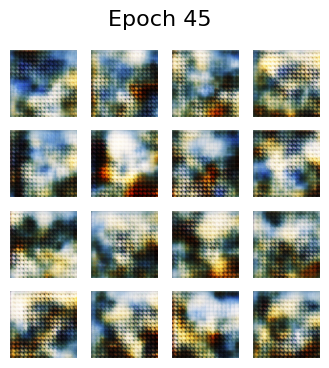


Epoch 46/100
Generator Loss: 1.8277, Discriminator Loss: 1.0858

Epoch 47/100
Generator Loss: 1.8443, Discriminator Loss: 0.8175

Epoch 48/100
Generator Loss: 1.6771, Discriminator Loss: 0.9983

Epoch 49/100
Generator Loss: 2.2803, Discriminator Loss: 0.8887

Epoch 50/100
Generator Loss: 1.3037, Discriminator Loss: 1.0668


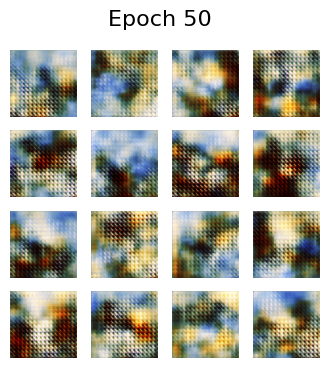


Epoch 51/100
Generator Loss: 1.9494, Discriminator Loss: 0.6610

Epoch 52/100
Generator Loss: 2.1708, Discriminator Loss: 0.8601

Epoch 53/100
Generator Loss: 2.1216, Discriminator Loss: 0.7149

Epoch 54/100
Generator Loss: 1.8956, Discriminator Loss: 0.9102

Epoch 55/100
Generator Loss: 1.3345, Discriminator Loss: 0.8969


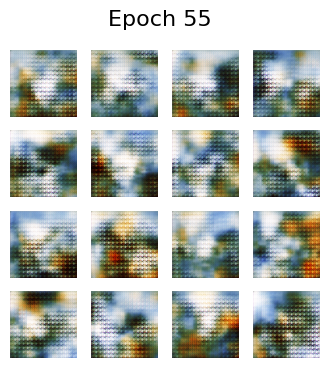


Epoch 56/100
Generator Loss: 2.1227, Discriminator Loss: 0.7063

Epoch 57/100
Generator Loss: 1.3786, Discriminator Loss: 1.1818

Epoch 58/100
Generator Loss: 1.7644, Discriminator Loss: 0.8820

Epoch 59/100
Generator Loss: 2.6497, Discriminator Loss: 1.0208

Epoch 60/100
Generator Loss: 1.1734, Discriminator Loss: 0.6761


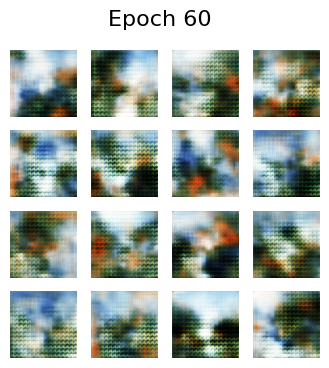


Epoch 61/100
Generator Loss: 1.5517, Discriminator Loss: 1.0553

Epoch 62/100
Generator Loss: 1.9286, Discriminator Loss: 0.8137

Epoch 63/100
Generator Loss: 1.6366, Discriminator Loss: 0.8512

Epoch 64/100
Generator Loss: 2.6102, Discriminator Loss: 0.5904

Epoch 65/100
Generator Loss: 1.9318, Discriminator Loss: 1.0289


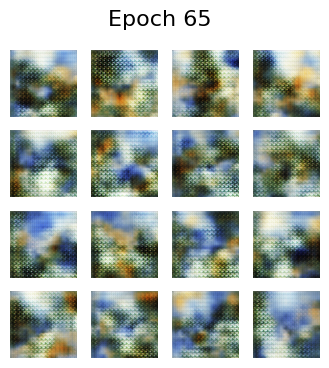


Epoch 66/100
Generator Loss: 1.8801, Discriminator Loss: 1.0138

Epoch 67/100
Generator Loss: 1.8622, Discriminator Loss: 0.6718

Epoch 68/100
Generator Loss: 2.1355, Discriminator Loss: 0.3561

Epoch 69/100
Generator Loss: 2.2912, Discriminator Loss: 0.5312

Epoch 70/100
Generator Loss: 0.6890, Discriminator Loss: 1.5146


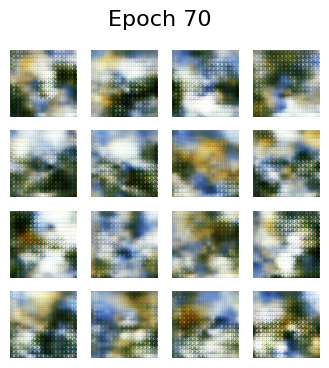


Epoch 71/100
Generator Loss: 2.5336, Discriminator Loss: 0.7726

Epoch 72/100
Generator Loss: 0.8154, Discriminator Loss: 1.4224

Epoch 73/100
Generator Loss: 2.0598, Discriminator Loss: 0.6886

Epoch 74/100
Generator Loss: 3.7202, Discriminator Loss: 0.9815

Epoch 75/100
Generator Loss: 2.5805, Discriminator Loss: 0.5887


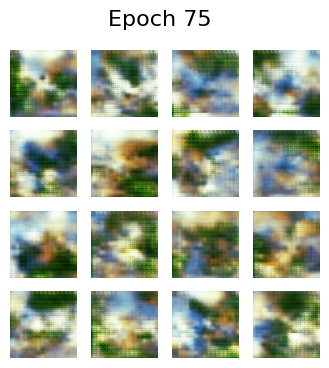


Epoch 76/100
Generator Loss: 2.6327, Discriminator Loss: 1.0891

Epoch 77/100
Generator Loss: 2.3177, Discriminator Loss: 1.8132

Epoch 78/100
Generator Loss: 2.6438, Discriminator Loss: 0.9191

Epoch 79/100
Generator Loss: 1.6958, Discriminator Loss: 0.7910

Epoch 80/100
Generator Loss: 3.8210, Discriminator Loss: 0.4849


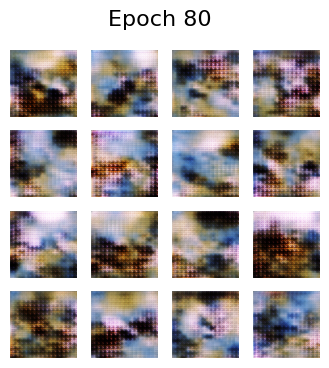


Epoch 81/100
Generator Loss: 4.0589, Discriminator Loss: 0.5394

Epoch 82/100
Generator Loss: 3.7228, Discriminator Loss: 0.5280

Epoch 83/100
Generator Loss: 2.8250, Discriminator Loss: 0.4428

Epoch 84/100
Generator Loss: 3.0067, Discriminator Loss: 2.1126

Epoch 85/100
Generator Loss: 3.3974, Discriminator Loss: 0.6097


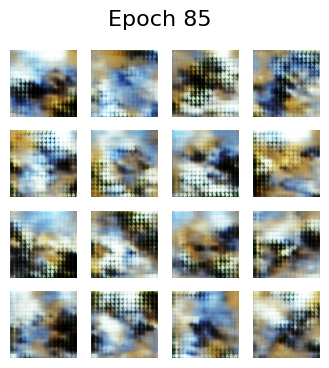


Epoch 86/100
Generator Loss: 2.7151, Discriminator Loss: 0.8261

Epoch 87/100
Generator Loss: 1.4463, Discriminator Loss: 1.0389

Epoch 88/100
Generator Loss: 4.3080, Discriminator Loss: 0.7551

Epoch 89/100
Generator Loss: 3.5557, Discriminator Loss: 0.4153

Epoch 90/100
Generator Loss: 3.9127, Discriminator Loss: 0.2347


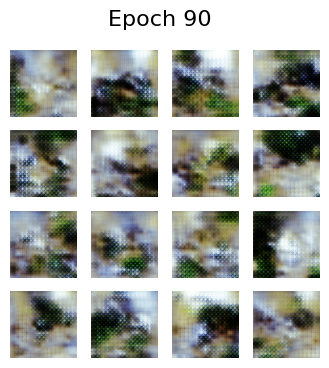


Epoch 91/100
Generator Loss: 3.2243, Discriminator Loss: 0.9475

Epoch 92/100
Generator Loss: 3.3161, Discriminator Loss: 0.7433

Epoch 93/100
Generator Loss: 3.2801, Discriminator Loss: 0.6384

Epoch 94/100
Generator Loss: 2.4502, Discriminator Loss: 0.9449

Epoch 95/100
Generator Loss: 3.7413, Discriminator Loss: 0.5293


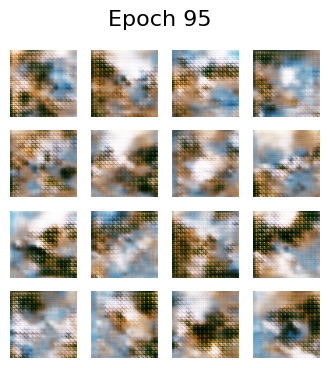


Epoch 96/100
Generator Loss: 3.7298, Discriminator Loss: 0.4638

Epoch 97/100
Generator Loss: 4.5765, Discriminator Loss: 0.8129

Epoch 98/100
Generator Loss: 3.2845, Discriminator Loss: 0.5002

Epoch 99/100
Generator Loss: 4.0905, Discriminator Loss: 0.3724

Epoch 100/100
Generator Loss: 6.4158, Discriminator Loss: 0.4366


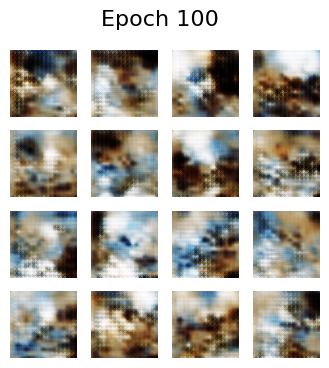

In [19]:
EPOCHS = 100
train(dataset, EPOCHS)

In [20]:
def generate_samples(generator_model, noise_dim=100, n=4):
    noise = tf.random.normal([n*n, noise_dim])
    images = generator_model(noise, training=False)
    images = (images + 1) / 2.0

    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(n, n))
    for i in range(n*n):
        plt.subplot(n, n, i + 1)
        plt.imshow(images[i].numpy())
        plt.axis('off')
    plt.tight_layout()
    plt.show()

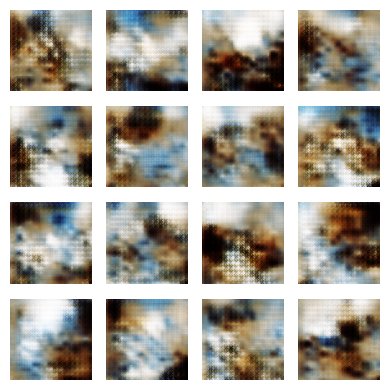

In [21]:
generate_samples(gen)

# Conclusion

Based on the generated images the generator started to pick up on some of the subtleties of a Monet Style Painting but it is very much not close to what it should be. The GAN training is expensive when it comes to resources so possibly training with more powerful GPUs could result in some better results. A more powerful GPU I could experiment with more layers or a progressive GAN model that starts with a smaller size. For this project I used DCGAN which used a noise vector to generate images. There is no input image being fed into to the model it is just generating something that would look like a Monet painting. Another way I could do it is use the photo_jpg folder and convert actual photos into Monet Style Painting using a CycleGAN. CycleGANs use image-image translation so I could feed input photos that would translate it into a Monet style painting. Pix2Pix is also another image paired translation unlike CycleGans it needs paied datasets. The score I received from this submissinon was 348.88910. 

Takeaways: I learned a lot about how GANs work and during this project explored DCGANs, CycleGANs, and Pix2Pix. I learned about the different use cases for each and I ended up using DCGANS for this project. GAN's are a powerful tool for image generation and I plan on continuing to work with them. For this model I also used a GPU to accelerate training. I was interested to see how it affected the speed and wanted to train the model using more epochs as well. Thanks to using a GPU I was able to run with 100 epochs faster and got to see much better results compared to a lower number of epochs. 

# References



In [22]:
'''output_dir = "../images"
os.makedirs(output_dir, exist_ok=True)

image_id = 0
total_images = 7000
BATCH_SIZE = 8  

start = time.time()
while image_id < total_images:
    current_batch_size = min(BATCH_SIZE, total_images - image_id)
    noise = tf.random.normal([current_batch_size, noise_dim])
    generated_images = gen(noise, training=False)
    generated_images = 0.5 * generated_images + 0.5
    generated_images = (generated_images * 255).numpy().astype('uint8')

    for img in generated_images:
        im = Image.fromarray(img)
        im.save(os.path.join(output_dir, f"{image_id}.jpg"))
        image_id += 1

'''

'output_dir = "../images"\nos.makedirs(output_dir, exist_ok=True)\n\nimage_id = 0\ntotal_images = 7000\nBATCH_SIZE = 8  \n\nstart = time.time()\nwhile image_id < total_images:\n    current_batch_size = min(BATCH_SIZE, total_images - image_id)\n    noise = tf.random.normal([current_batch_size, noise_dim])\n    generated_images = gen(noise, training=False)\n    generated_images = 0.5 * generated_images + 0.5\n    generated_images = (generated_images * 255).numpy().astype(\'uint8\')\n\n    for img in generated_images:\n        im = Image.fromarray(img)\n        im.save(os.path.join(output_dir, f"{image_id}.jpg"))\n        image_id += 1\n\n'

In [23]:

#shutil.make_archive("/kaggle/working/images", 'zip', output_dir)